In [1]:
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import netwulf
import copy
import community
import seaborn as sns
import pickle as pkl
import seaborn as sns

DATA_PATH = 'data/'

In [2]:
descriptions_df = pd.read_csv(DATA_PATH + "books_descriptions.csv")
df = pd.read_json(DATA_PATH + 'goodreads_book_works.json', lines=True)


In [4]:
with open(DATA_PATH + 'edges.pickle', 'rb') as f:
    test_edges = pkl.load(f)

In [6]:
G = nx.Graph()

# Iterate over the items in the dictionary and add edges with weights
for nodes, weight in test_edges.items():
    if weight > 0:
        node_1, node_2 = nodes
        G.add_edge(node_1, node_2, weight=weight)

### Louvain

In [8]:
# Function that applies the Louvain algorithm to a grap, and returns communities
def louvain_communities(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm
    
    # Reformat the partitioning
    communities = {}
    for node, community_id in partition.items():
        if community_id in communities:
            communities[community_id].append(node)
        else:
            communities[community_id] = [node]
    
    return list(communities.values())

def louvain_communities_faster(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm
    
    # Reformat the partitioning
    communities = {}
    for node, community_id in tqdm(partition.items()):
        communities.setdefault(community_id, []).append(node)
    
    return list(communities.values())

In [10]:
res = louvain_communities_faster(G) # This took 1 hour to run with test dataset

### Modularity

In [13]:
#Modularity function
def modularity(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """
    
    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = {community: 0 for community in range(num_of_communities)}
    tot_degree = {community: 0 for community in range(num_of_communities)}
    
    # Dictionary to map node IDs to community IDs
    communities_lookup = {node: community for community, nodes in enumerate(communities) for node in nodes}

    # Count the number of links within each community and the total degree of each community
    for (node_1, node_2) in G.edges():
        node_1_community = communities_lookup[node_1]
        node_2_community = communities_lookup[node_2]
        
        # Since we go through all edges, we also get the degree of all nodes
        tot_degree[node_1_community] += 1
        tot_degree[node_2_community] += 1
        
        # If the nodes are in the same community, add one to that community's link count
        if node_1_community == node_2_community:
            links_in_community[node_1_community] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M

def modularity_faster(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """
    
    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = [0] * num_of_communities
    tot_degree = [0] * num_of_communities
    nodes_in_community = [set(c) for c in communities]

    # Compute the total degree of nodes in each community
    for node, community in enumerate(nodes_in_community):
        community_edges = G.subgraph(community).edges()
        community_degree = sum([G.degree(n) for n in community])
        tot_degree[node] = community_degree
        for n1, n2 in community_edges:
            if n1 in community and n2 in community:
                links_in_community[node] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M

def modularity_nx(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """

    # Use the louvain method to find communities
    partition = {node: community_id for community_id, nodes in enumerate(communities) for node in nodes}

    # Compute the modularity
    M = community.modularity(partition, G)

    return M


In [14]:
mod = modularity_nx(G,res) #Took two minutes

In [15]:
mod_2 = modularity_faster(G,res) # Took two minutes

### Confusion Matrix

In [47]:
graph1 = {
    1: ['Action', 'Thriller', 'Drama'],
    2: ['Comedy', 'Romance', 'Drama'],
    3: ['Action', 'Adventure', 'Fantasy'],
    4: ['Horror', 'Mystery', 'Thriller'],
    5: ['Romance', 'Drama', 'Comedy'],
    6: ['Action', 'Thriller', 'Adventure'],
    7: ['Horror', 'Mystery', 'Thriller'],
    8: ['Comedy', 'Drama', 'Romance'],
    9: ['Adventure', 'Fantasy', 'Action'],
    10: ['Comedy', 'Romance', 'Drama'],
    11: ['Action', 'Thriller', 'Adventure'],
    12: ['Mystery', 'Horror', 'Thriller'],
    13: ['Drama', 'Romance', 'Comedy'],
    14: ['Action', 'Adventure', 'Fantasy'],
    15: ['Mystery', 'Thriller', 'Horror'],
    16: ['Romance', 'Comedy', 'Drama'],
    17: ['Adventure', 'Action', 'Fantasy'],
    18: ['Mystery', 'Thriller', 'Horror'],
    19: ['Drama', 'Comedy', 'Romance'],
    20: ['Action', 'Thriller', 'Adventure'],
    21: ['Horror', 'Mystery', 'Thriller'],
    22: ['Comedy', 'Romance', 'Drama'],
    23: ['Action', 'Adventure', 'Fantasy'],
    24: ['Horror', 'Mystery', 'Thriller'],
    25: ['Drama', 'Comedy', 'Romance']}

graph2 = {
    1: ['Action', 'Thriller', 'Adventure'],
    2: ['Mystery', 'Horror', 'Thriller'],
    3: ['Romance', 'Drama', 'Comedy'],
    4: ['Adventure', 'Action', 'Fantasy'],
    5: ['Mystery', 'Thriller', 'Horror'],
    6: ['Comedy', 'Drama', 'Romance'],
    7: ['Action', 'Thriller', 'Adventure'],
    8: ['Horror', 'Mystery', 'Thriller'],
    9: ['Romance', 'Comedy', 'Drama'],
    10: ['Adventure', 'Fantasy', 'Action'],
    11: ['Mystery', 'Thriller', 'Horror'],
    12: ['Drama', 'Comedy', 'Romance'],
    13: ['Action', 'Thriller', 'Adventure'],
    14: ['Horror', 'Mystery', 'Thriller'],
    15: ['Comedy', 'Romance', 'Drama'],
    16: ['Action', 'Adventure', 'Fantasy'],
    17: ['Mystery', 'Horror', 'Thriller'],
    18: ['Romance', 'Drama', 'Comedy'],
    19: ['Adventure', 'Action', 'Fantasy'],
    20: ['Mystery', 'Thriller', 'Horror'],
    21: ['Drama', 'Comedy', 'Romance'],
    22: ['Action', 'Thriller', 'Adventure']}

In [45]:
def create_confusion_matrix(graph1, graph2):
    """
    Create a confusion matrix using seaborn, comparing two graphs.

    Parameters:
        - graph1 (dict): a dictionary of book IDs and their groups in graph 1
        - graph2 (dict): a dictionary of book IDs and their groups in graph 2

    Returns:
        - A confusion matrix plot
    """
    # Combine the dictionaries and get a list of all possible groups
    all_groups = list(set([group for groups in list(graph1.values()) + list(graph2.values()) for group in groups]))

    # Create a dictionary to map groups to integers
    group_map = {group: i for i, group in enumerate(all_groups)}

    # Create a matrix of zeros to store the counts
    matrix = np.zeros((len(all_groups), len(all_groups)))

    # Fill in the matrix with the counts
    for book_id, groups1 in graph1.items():
        groups2 = graph2.get(book_id, [])
        for group1 in groups1:
            for group2 in groups2:
                matrix[group_map[group1], group_map[group2]] += 1

    # Create a dataframe from the matrix
    df_cm = pd.DataFrame(matrix, index=all_groups, columns=all_groups)

    # Create the confusion matrix plot using seaborn
    sns.set(font_scale=1.4)
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="g")

    # Add labels to the plot
    ax.set_xlabel('Graph 2')
    ax.set_ylabel('Graph 1')

    # Show the plot
    plt.show()

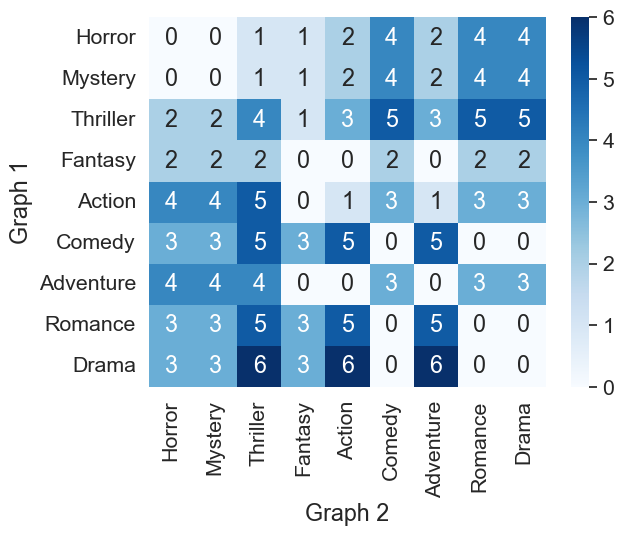

In [48]:
create_confusion_matrix(graph1,graph2)